In [ ]:
'''
#determined from autocorrelation between two filter maps of an image
#the autocorrelation is found out to determine the style of an image
#trained CNN can find style of one image and apply it to the content image
#content loss : 1/2((Cc - Tc)**2).sum()
#gram matrix : vectorize the values in the layer -- flattened the 3d layer to a 2d layer * take transpose and mutiply
finally contained non localised features in the image
-- shows similarity between the feature maps
find diff between style image and content image we calculate the difference between the gram matrices
final loss is defined as a(wi((Ts - Ss)**2).sum())
add content and style loss to eventually get the total loss
multiplied with weights al1+bl2
pretrained VGG19
'''

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models , transforms
from torch import optim
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
vgg = models.vgg19(pretrained = True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [4]:
def load_image(path , max_size=400 , shape = None):
    image = Image.open(path).convert('RGB')
    if(max(image.size)) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None :
        size = shape
    transform_test = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    return transform_test(image)[:3,:,:].unsqueeze(0) 

In [5]:
content = load_image('/home/nilesh/Desktop/MY FILES/ML_REVIEW/octopus.jpg')
stylized = load_image('/home/nilesh/Desktop/MY FILES/ML_REVIEW/imgstyle.jpg' , shape=content.shape[-2:])

In [6]:
def im_convert(tensor):
    
    image = tensor.clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [7]:
vgg._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace)), ('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('17', ReLU(inplace)), ('18', MaxPool2d(kernel_size=2, str

In [8]:
def get_featured_images(image):
    layers = {'0': 'conv1_1', 
                 '5' : 'conv2_1',
                 '10' : 'conv3_1',
                 '19' : 'conv4_1',
                  '21' : 'conv5_1',
                  '28' : 'conv6_1'
                 }
    feature = {}
    x = image
    for no , layer in vgg._modules.items():
        x = layer(x)
        if no in layers:
            feature[layers[no]] = x
    return feature

In [9]:
def gram_matrix(tensor):
    _ , d , h , w = tensor.size()
    new_tensor = tensor.view(d , h*w)
    return torch.mm(new_tensor , new_tensor.t())

In [10]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  
style_weight = 1e6 
target = content.clone().requires_grad_(True)

epoch 1 106458912.0
epoch 2 97715960.0
epoch 3 91267136.0
epoch 4 86286904.0
epoch 5 82297992.0
epoch 6 78999312.0
epoch 7 76190960.0
epoch 8 73738624.0
epoch 9 71552288.0
epoch 10 69569416.0


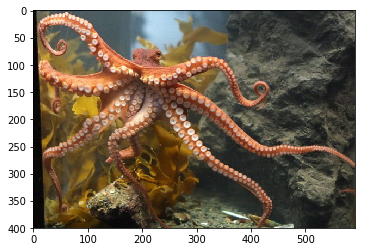

epoch 11 67747296.0
epoch 12 66056104.0
epoch 13 64472448.0
epoch 14 62982012.0
epoch 15 61571892.0
epoch 16 60232892.0
epoch 17 58959816.0
epoch 18 57747332.0
epoch 19 56590644.0
epoch 20 55485296.0


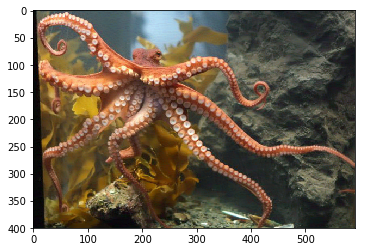

epoch 21 54427248.0
epoch 22 53413052.0
epoch 23 52440264.0
epoch 24 51505644.0
epoch 25 50605824.0
epoch 26 49738568.0
epoch 27 48901328.0
epoch 28 48091452.0
epoch 29 47307724.0
epoch 30 46548564.0


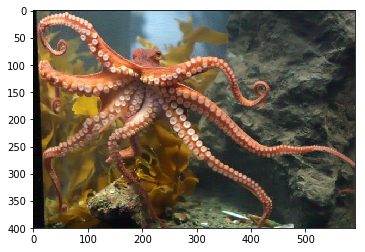

epoch 31 45812768.0
epoch 32 45099416.0
epoch 33 44406924.0
epoch 34 43734164.0
epoch 35 43079592.0
epoch 36 42442612.0
epoch 37 41822416.0
epoch 38 41217780.0
epoch 39 40627856.0
epoch 40 40052004.0


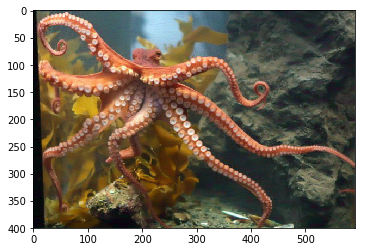

epoch 41 39489352.0
epoch 42 38939224.0
epoch 43 38401144.0
epoch 44 37874240.0
epoch 45 37358060.0
epoch 46 36851860.0
epoch 47 36355052.0
epoch 48 35867156.0
epoch 49 35387732.0
epoch 50 34916232.0


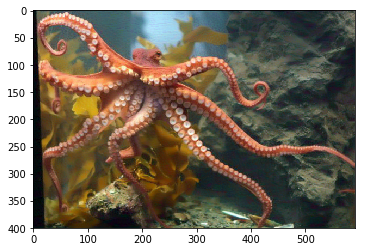

epoch 51 34452192.0
epoch 52 33995180.0
epoch 53 33544822.0
epoch 54 33100824.0
epoch 55 32662932.0
epoch 56 32230758.0
epoch 57 31804100.0
epoch 58 31382796.0
epoch 59 30966534.0
epoch 60 30555124.0


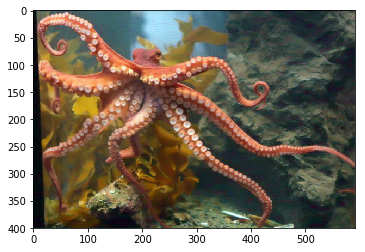

epoch 61 30148260.0
epoch 62 29745862.0
epoch 63 29347782.0
epoch 64 28953926.0
epoch 65 28564048.0
epoch 66 28177930.0
epoch 67 27795370.0
epoch 68 27416300.0
epoch 69 27040626.0
epoch 70 26668290.0


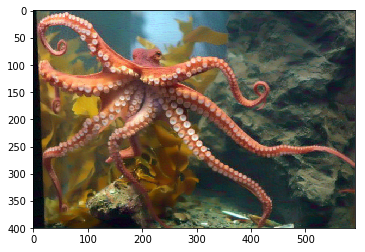

epoch 71 26299218.0
epoch 72 25933320.0
epoch 73 25570546.0
epoch 74 25210814.0
epoch 75 24854088.0
epoch 76 24500286.0
epoch 77 24149448.0
epoch 78 23801534.0
epoch 79 23456466.0
epoch 80 23114346.0


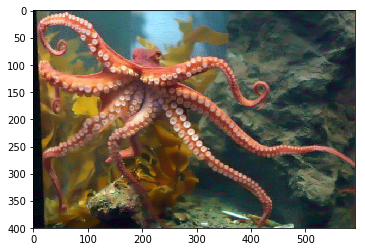

epoch 81 22775108.0
epoch 82 22438724.0
epoch 83 22105146.0
epoch 84 21774452.0
epoch 85 21446696.0
epoch 86 21121814.0
epoch 87 20799822.0
epoch 88 20480690.0
epoch 89 20164458.0
epoch 90 19851150.0


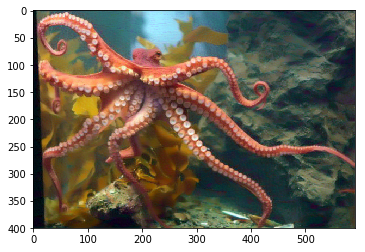

epoch 91 19540824.0
epoch 92 19233524.0
epoch 93 18929232.0
epoch 94 18627964.0
epoch 95 18329810.0
epoch 96 18034794.0
epoch 97 17742940.0
epoch 98 17454300.0
epoch 99 17168840.0
epoch 100 16886590.0


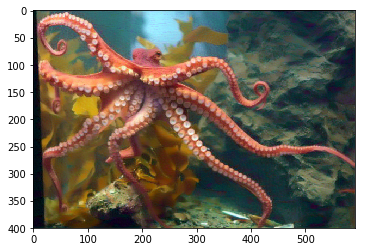

epoch 101 16607540.0
epoch 102 16331748.0
epoch 103 16059265.0
epoch 104 15790084.0
epoch 105 15524282.0
epoch 106 15261875.0
epoch 107 15002922.0
epoch 108 14747447.0
epoch 109 14495451.0
epoch 110 14246991.0


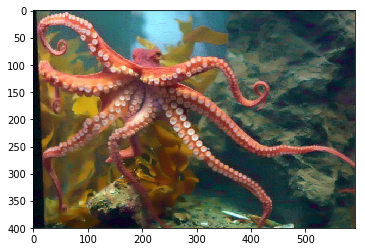

epoch 111 14002090.0
epoch 112 13760803.0
epoch 113 13523146.0
epoch 114 13289087.0
epoch 115 13058671.0
epoch 116 12831914.0
epoch 117 12608801.0
epoch 118 12389326.0
epoch 119 12173507.0
epoch 120 11961363.0


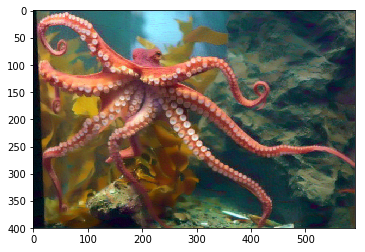

epoch 121 11752880.0
epoch 122 11548074.0
epoch 123 11346966.0
epoch 124 11149542.0
epoch 125 10955773.0
epoch 126 10765691.0
epoch 127 10579282.0
epoch 128 10396531.0
epoch 129 10217398.0
epoch 130 10041869.0


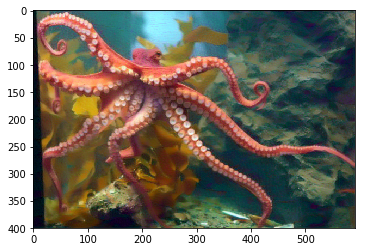

epoch 131 9869943.0
epoch 132 9701601.0
epoch 133 9536815.0
epoch 134 9375543.0
epoch 135 9217779.0
epoch 136 9063465.0
epoch 137 8912532.0
epoch 138 8764984.0
epoch 139 8620752.0
epoch 140 8479783.0


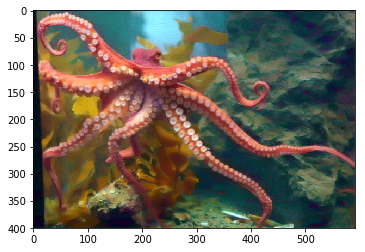

epoch 141 8342055.5
epoch 142 8207547.5
epoch 143 8076197.0
epoch 144 7947964.0
epoch 145 7822790.5
epoch 146 7700625.5
epoch 147 7581414.0
epoch 148 7465133.0
epoch 149 7351720.5
epoch 150 7241117.0


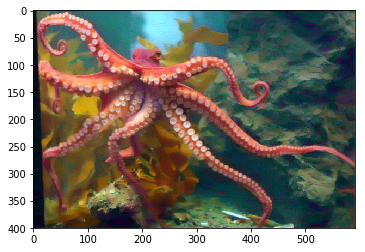

epoch 151 7133266.0
epoch 152 7028140.0
epoch 153 6925670.0
epoch 154 6825784.5
epoch 155 6728427.5
epoch 156 6633554.5
epoch 157 6541110.0
epoch 158 6451026.5
epoch 159 6363256.0
epoch 160 6277740.5


epoch 161 6194399.5
epoch 162 6113190.5
epoch 163 6034069.5
epoch 164 5956962.5
epoch 165 5881843.5
epoch 166 5808655.0
epoch 167 5737338.0
epoch 168 5667857.5
epoch 169 5600129.0
epoch 170 5534111.0


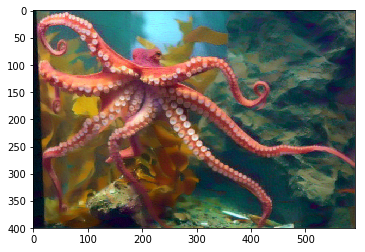

epoch 171 5469769.5
epoch 172 5407049.5
epoch 173 5345894.0
epoch 174 5286253.5
epoch 175 5228075.0
epoch 176 5171326.5
epoch 177 5115962.5
epoch 178 5061930.5
epoch 179 5009197.0
epoch 180 4957722.0


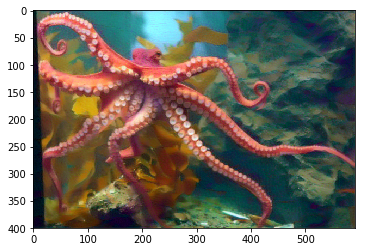

epoch 181 4907461.0
epoch 182 4858377.0
epoch 183 4810427.0
epoch 184 4763575.5
epoch 185 4717798.5
epoch 186 4673059.5
epoch 187 4629321.0
epoch 188 4586550.5
epoch 189 4544725.5
epoch 190 4503815.5


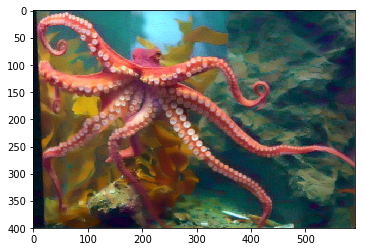

epoch 191 4463785.5
epoch 192 4424601.5
epoch 193 4386243.5
epoch 194 4348687.5
epoch 195 4311913.5
epoch 196 4275883.0
epoch 197 4240585.5
epoch 198 4205979.5
epoch 199 4172050.0
epoch 200 4138780.5


In [11]:
optimizer = optim.Adam([target] , lr = 0.005)
original_features = get_featured_images(content)
style_features = get_featured_images(stylized)
style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}


for epoch in range(1 , 201):
    changed_features = get_featured_images(target)
    content_loss = torch.mean((original_features['conv5_1'] - changed_features['conv5_1'])**2)
    style_loss = 0
    
    for layer in style_weights:
        gram_target = gram_matrix(changed_features[layer])
        _ , d , h , w = changed_features[layer].shape
        gram_style = style_grams[layer]
        style_loss += (style_weights[layer]*torch.mean((gram_target - gram_style)**2))/(d*h*w)
        
    total_loss = content_weight*content_loss + style_weight*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    print('epoch' , epoch , total_loss.item())
    
    if epoch%10 == 0:
        plt.imshow(im_convert(target))
        plt.show()